In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import kagglehub
# from kagglehub import KaggleDatasetAdapter

In [5]:
file_path = "predictive_maintenance_dataset.csv"

df = pd.read_csv(file_path)

print("First 5 records:")
print(df.head())

First 5 records:
       date    device  failure    metric1  metric2  metric3  metric4  metric5  \
0  1/1/2015  S1F01085        0  215630672       55        0       52        6   
1  1/1/2015  S1F0166B        0   61370680        0        3        0        6   
2  1/1/2015  S1F01E6Y        0  173295968        0        0        0       12   
3  1/1/2015  S1F01JE0        0   79694024        0        0        0        6   
4  1/1/2015  S1F01R2B        0  135970480        0        0        0       15   

   metric6  metric7  metric8  metric9  
0   407438        0        0        7  
1   403174        0        0        0  
2   237394        0        0        0  
3   410186        0        0        0  
4   313173        0        0        3  


In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['device_encoded'] = le.fit_transform(df['device'])

In [8]:
features = ['metric1', 'metric2', 'metric3', 'metric4', 'metric5',
            'metric6', 'metric7', 'metric8', 'metric9']
scaler = StandardScaler()
df[features]=scaler.fit_transform(df[features])


In [9]:
print(df['failure'].value_counts(normalize=True))

failure
0    0.999149
1    0.000851
Name: proportion, dtype: float64


In [10]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# X and y (already cleaned and scaled)
X = df.drop(['failure', 'date', 'device'], axis=1)
y = df['failure']

# 1. Split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 2. Apply SMOTE only on training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ---- Logistic Regression ----
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_resampled, y_train_resampled)
y_pred_logreg = logreg.predict(X_test)
y_proba_logreg = logreg.predict_proba(X_test)[:, 1]

print("Logistic Regression:")
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))
print("ROC AUC:", roc_auc_score(y_test, y_proba_logreg))





Logistic Regression:
[[23694  1184]
 [   11    10]]
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     24878
           1       0.01      0.48      0.02        21

    accuracy                           0.95     24899
   macro avg       0.50      0.71      0.50     24899
weighted avg       1.00      0.95      0.97     24899

ROC AUC: 0.7754068425344252


In [ ]:

# ---- Random Forest ----
rf = RandomForestClassifier()
rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\n📌 Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_proba_rf))


📌 Random Forest:
[[24871     7]
 [   19     2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24878
           1       0.22      0.10      0.13        21

    accuracy                           1.00     24899
   macro avg       0.61      0.55      0.57     24899
weighted avg       1.00      1.00      1.00     24899

ROC AUC: 0.7755810258824971


In [ ]:
# ---- XGBoost ----
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]

print("\n📌 XGBoost:")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("ROC AUC:", roc_auc_score(y_test, y_proba_xgb))


📌 XGBoost:
[[24869     9]
 [   19     2]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     24878
           1       0.18      0.10      0.12        21

    accuracy                           1.00     24899
   macro avg       0.59      0.55      0.56     24899
weighted avg       1.00      1.00      1.00     24899

ROC AUC: 0.739562397834767


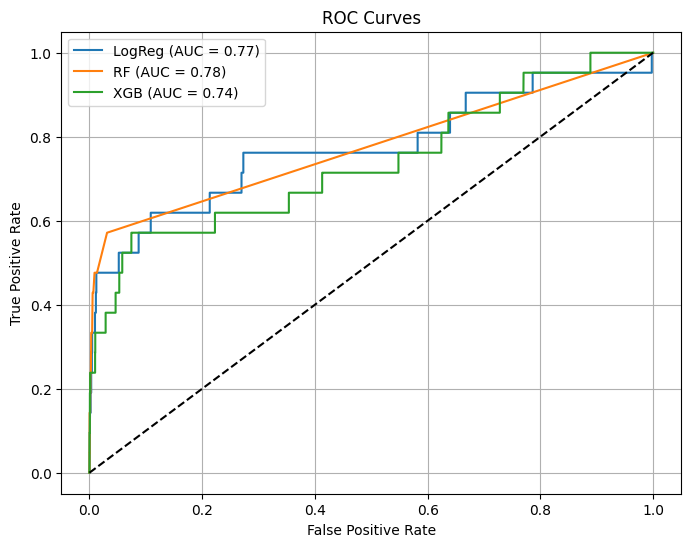

In [ ]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(8,6))
for name, y_proba in zip(['LogReg', 'RF', 'XGB'],
                         [y_proba_logreg, y_proba_rf, y_proba_xgb]):
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.grid()
plt.show()

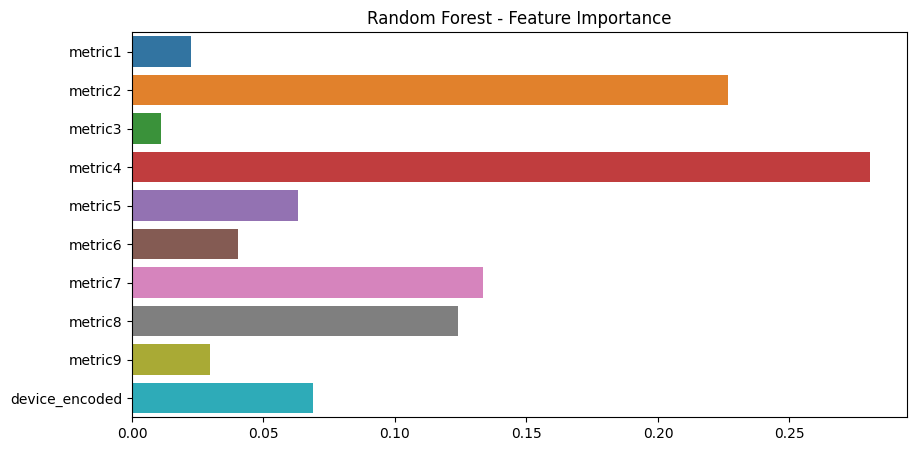

In [ ]:
importances = rf.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10,5))
sns.barplot(x=importances, y=feature_names)
plt.title("Random Forest - Feature Importance")
plt.show()


In [ ]:
import time
import random

def simulate_prediction(model, n=10):
    for _ in range(n):
        idx = random.randint(0, len(X_test)-1)
        sample = X_test.iloc[[idx]]
        proba = model.predict_proba(sample)[0][1]
        pred = model.predict(sample)[0]
        print(f"\n🔧 Sensor Reading #{idx}:")
        print(f"Failure Probability: {proba:.4f}")
        print("⚠️ Predicted Status:", "FAILURE" if pred == 1 else "OK")
        time.sleep(1)

simulate_prediction(xgb)



🔧 Sensor Reading #7453:
Failure Probability: 0.0004
⚠️ Predicted Status: OK

🔧 Sensor Reading #23547:
Failure Probability: 0.0000
⚠️ Predicted Status: OK

🔧 Sensor Reading #14159:
Failure Probability: 0.0007
⚠️ Predicted Status: OK

🔧 Sensor Reading #7702:
Failure Probability: 0.0004
⚠️ Predicted Status: OK

🔧 Sensor Reading #19694:
Failure Probability: 0.0010
⚠️ Predicted Status: OK

🔧 Sensor Reading #13531:
Failure Probability: 0.0062
⚠️ Predicted Status: OK

🔧 Sensor Reading #8498:
Failure Probability: 0.0000
⚠️ Predicted Status: OK

🔧 Sensor Reading #2456:
Failure Probability: 0.0000
⚠️ Predicted Status: OK

🔧 Sensor Reading #13830:
Failure Probability: 0.0000
⚠️ Predicted Status: OK

🔧 Sensor Reading #23625:
Failure Probability: 0.0000
⚠️ Predicted Status: OK


In [ ]:
import pickle

# Save models
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(xgb, f)

with open("rf_model.pkl", "wb") as f:
    pickle.dump(rf, f)

with open("logreg_model.pkl", "wb") as f:
    pickle.dump(logreg, f)

In [ ]:
# Save scaler (only if you scaled features like metric1 to metric9)
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Save label encoder (if you encoded 'device')
with open("device_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [ ]:
import streamlit as st
import numpy as np
import pickle

# Load trained model (pick one!)
with open("xgb_model.pkl", "rb") as f:
    model = pickle.load(f)

# Load scaler and encoder
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)

with open("device_encoder.pkl", "rb") as f:
    device_encoder = pickle.load(f)



In [ ]:
pip install streamlit
jupyter nbconvert --to script predictive_maintenance.ipynb



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 60.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 82.4 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import streamlit as st
import numpy as np
import joblib

model = xgb  # or save/load from disk
st.title("🛠️ Predictive Maintenance Dashboard")

metrics = [st.slider(f"Metric {i+1}", -3.0, 3.0, 0.0) for i in range(9)]
device = st.number_input("Device Encoded ID", 0)

sample = np.array([*metrics, device]).reshape(1, -1)
pred = model.predict(sample)[0]
prob = model.predict_proba(sample)[0][1]

st.markdown(f"**Failure Probability:** `{prob:.2f}`")
st.markdown(f"**Prediction:** {'⚠️ FAILURE' if pred else '✅ SAFE'}")
!streamlit run app.py


2025-03-22 10:44:21.568 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 10:44:21.569 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 10:44:21.571 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 10:44:21.572 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 10:44:21.573 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 10:44:21.574 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 10:44:21.574 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-22 10:44:21.575 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
